# Deep Convolutional - Stylized Image Colorization
Image colorization of grayscale to rgb directly. This is order to see the limitation of using RGB as the output when computing the loss. Spoiler alert the results are not great with stylized images. There are several possiblie reasons, one is that the RGB color space is not the best to find patterns. Another is that performing image colorization of real images has a inherit preditcable output. A sunflower is most likly yellow and etc. Whereas stylized images has *no* correct way to colorize. But rather only what looks good.

In [1]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy scikit-image

## Import all Modules and Configure GPU

In [ ]:
import os
import keras_tuner as kt
from numpy import asarray
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import pathlib
import os.path
import math
import PIL
import PIL.Image
import imageio.v2 as imageio
import glob
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" # Debug only

## Configure GPU

In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
# Initialize tf.distribute.MirroredStrategy

strategy = tf.distribute.MirroredStrategy(devices=None)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


2023-03-14 17:59:42.460029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 17:59:42.460351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 17:59:42.488966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 17:59:42.489183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 17:59:42.489337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [ ]:
tf.__version__

'2.9.1'

### Setup Result Directory

In [ ]:
root_dir = "result/stylized_colorizing_rgb_color_space"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)

## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [ ]:
def load_from_directory(data_dir, train_subdir, test_subdir, image_size, batch_size):
    def configure_for_performance(ds, AUTOTUNE, shuffleSize=0):
        BUFFER_SIZE = 10000
        if shuffleSize > 0:
            ds = ds.shuffle(buffer_size=shuffleSize, reshuffle_each_iteration=False)
        ds = ds.cache(filename='/tmp/StylizedColorizing', name='StylizedColorizing')
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    #
    data_train_dir = pathlib.Path(data_dir.as_posix() + "/" + train_subdir)
    image_count = len(list(data_train_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_train_dir, image_count))

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    # Translate [0,255] -> [0, 1]
    normalized_train_ds = train_ds.map(lambda x: normalization_layer(x) * 2.0 - 1.0)

    return configure_for_performance(tf.data.Dataset.zip((normalized_train_ds, normalized_train_ds)), AUTOTUNE, 0)


In [ ]:
IMAGE_SIZE = (128, 128)

EPOCHS = 8

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

data_directory_path = "data-colorize/"
data_dir = pathlib.Path(data_directory_path)

train_images = load_from_directory(data_dir, "", "", IMAGE_SIZE, BATCH_SIZE)  # .batch(batch_size=BATCH_SIZE)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))

IMAGE_SIZE = (128, 128, 3)

data-colorize: Found 0 files
Found 1263538 files belonging to 1 classes.
Number of batches 9872 of 128 elements


## Augment Data

In [ ]:

trainAug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(
        height_factor=(-0.05, -0.10),
        width_factor=(-0.05, -0.10)),
    layers.RandomRotation(0.4)
])

def AgumentFunc(x,y):
    aX = trainAug(x)
    return (tf.image.rgb_to_grayscale(aX), aX)

# apply augmentation image transformation to prevent overfitting.
trainAugmentedDS = (
    train_images
    .map(AgumentFunc,
         num_parallel_calls=tf.data.AUTOTUNE)
         .prefetch(buffer_size=tf.data.AUTOTUNE)
)

#Split data into train and validation
ds_size = len(trainAugmentedDS)
train_size = int(0.8 * ds_size)
val_size = int(0.2 * ds_size)
#Split data into train and validation
train_ds = trainAugmentedDS.take(train_size)
val_ds = trainAugmentedDS.skip(train_size).take(val_size)

# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_ds = train_ds.with_options(options)
# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
val_ds = val_ds.with_options(options)


## Present DataSet Examples

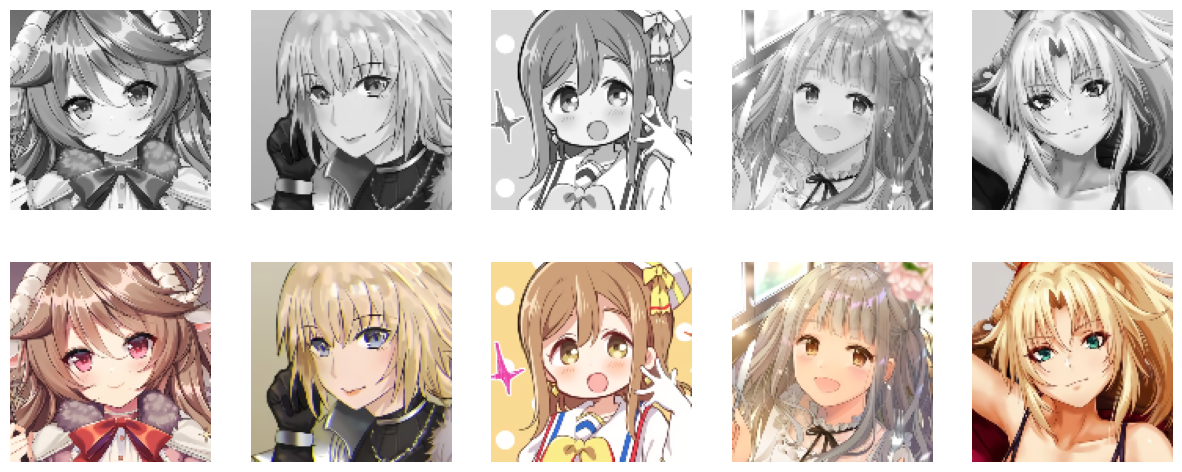

In [ ]:

num_examples_to_generate = 5

bathc_iter = iter(train_images)
image_batch, expected_batch = next(bathc_iter)

plt.figure(figsize=(15, 6))
for i in range(0, num_examples_to_generate):
    ax = plt.subplot(2, num_examples_to_generate, i + 1)
    trainImage, expectedImage = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0
    # Transform pixel values from [-1,1] to [0,1]
    plt.imshow((tf.image.rgb_to_grayscale(trainImage[:, :, :]).numpy().astype(dtype='float32') + 1.0) / 2.0, cmap='gray')
    plt.axis("off")
    ax = plt.subplot(2, num_examples_to_generate, num_examples_to_generate + 1 + i)
    # Transform pixel values from [-1,1] to [0,1]
    plt.imshow((expectedImage[:, :, :].numpy().astype(dtype='float32') + 1.0) / 2.0)
    plt.axis("off")
    if len(image_batch) - 1 == i:
        image_batch, expected_batch = next(bathc_iter)
plt.show()


### Augmented DataSet Example

2023-03-14 18:01:24.012526: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


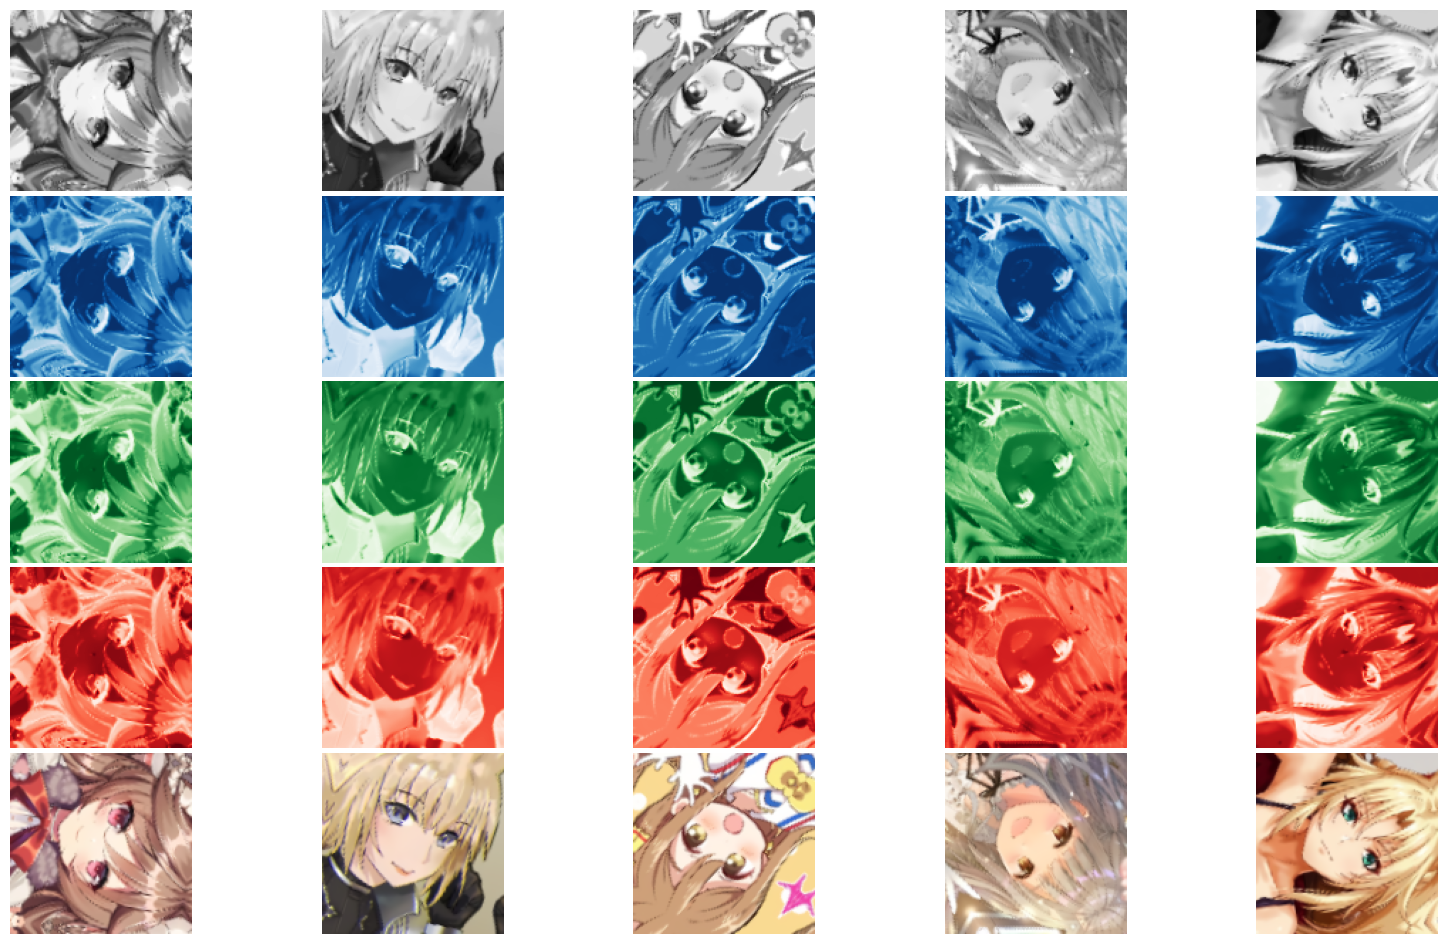

In [ ]:
num_examples_to_generate = 9

bathc_iter = iter(train_ds)
image_batch, expected_batch = next(bathc_iter)

nrCol = 5
plt.figure(figsize=(10 * 2, 12))
for i in range(0, 5):

    trainImage, expectedImage = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0

    # Transform pixel values from [-1,1] to [0,1]
    trainImage = (trainImage + 1.0) / 2.0
    expectedImage = (expectedImage + 1.0) / 2.0

    ax = plt.subplot(5, nrCol, nrCol * 0 + i + 1)
    plt.imshow(trainImage[:, :, :].numpy().astype(dtype='float32'), cmap='gray')
    plt.axis("off")

    ax = plt.subplot(5, nrCol, nrCol * 1 + i + 1)
    plt.imshow(expectedImage[:, :, 0].numpy().astype(dtype='float32'), cmap='Blues')
    plt.axis("off")

    ax = plt.subplot(5, nrCol, nrCol * 2 + i + 1)
    plt.imshow(expectedImage[:, :, 1].numpy().astype(dtype='float32'), cmap='Greens')
    plt.axis("off")

    ax = plt.subplot(5, nrCol, nrCol * 3 + i + 1)
    plt.imshow(expectedImage[:, :, 2].numpy().astype(dtype='float32'), cmap='Reds')
    plt.axis("off")

    ax = plt.subplot(5, nrCol, nrCol * 4 + i + 1)
    plt.imshow(expectedImage[:, :, :])
    plt.axis("off")

    if len(image_batch) - 1 == i:
        image_batch, expected_batch = next(bathc_iter)
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()


## Creating The Model
The model is created, similar to a audo encoding. However, in this model, there is node latent space. Instead it uses more of pure convolution network.

In [ ]:
def create_model(hp, input_shape,image_output_shape):
    model = tf.keras.Sequential()

    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    model.add(layers.Input(input_shape))

    num_layers = hp.Int('number_of_layers', min_value=2, max_value=4, step=1)

    hp_kernel_filter_size_l0 = hp.Int('kernel_filter_downscale', min_value=5, max_value=7, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (i + hp_kernel_filter_size_l0)

        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))
        
        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', strides=2, kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))
        #model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    hp_kernel_filter_size_l1 = hp.Int('kernel_filter_upscale', min_value=5, max_value=7, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (hp_kernel_filter_size_l1 - i)

        #model.add(layers.Conv2D(filter_size, (2, 2), strides=(2, 2), activation='relu', padding='same'))
        model.add(layers.UpSampling2D(size=(2, 2)))

        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

    model.add(layers.Conv2D(image_output_shape[2], (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.Activation(activation='tanh', dtype='float32'))

    mse_magnitude = hp.Float('mse_magnitude', 0, 1.0, step=0.1, default=0.0)
    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])

    def ssim_loss(y_true, y_pred):
        return 1.0 * (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))) + mse_magnitude * tf.keras.losses.mean_squared_error(y_true, y_pred)

    model.compile(optimizer=hp_optimizer,
                  loss=ssim_loss,
                  metrics=[ssim_loss,'accuracy'])

    return model


## Hyperparameter

In [ ]:

# 
image_input_shape =  (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
image_output_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)


def model_builder(hp):
    with strategy.scope():
        model = create_model(hp, image_input_shape, image_output_shape)
        return model

best_models = None
model = None

tuner = kt.Hyperband(model_builder,
                    objective='val_accuracy',
                    max_epochs=16,
                    factor=5,
                    directory='{0}/cache'.format(root_dir),
                    project_name=str.format('Colorizing - GrayScale Input - {0}', "Stylized"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5)
tuner.search(train_ds.take(1000), epochs=EPOCHS, batch_size=BATCH_SIZE,
            callbacks=[stop_early, tf.keras.callbacks.TerminateOnNaN()], validation_data=train_ds.skip(1000).take(150), verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)

model = tuner.hypermodel.build(best_hps)
model.summary()


Trial 11 Complete [07h 26m 34s]
val_accuracy: 0.7234591245651245

Best val_accuracy So Far: 0.7242531180381775
Total elapsed time: 07h 26m 34s

Search: Running Trial #12

Value             |Best Value So Far |Hyperparameter
he_uniform        |he_uniform        |kernel_initializer
3                 |3                 |number_of_layers
5                 |6                 |kernel_filter_downscale
6                 |7                 |kernel_filter_upscale
0.4               |0.8               |mse_magnitude
rmsprop           |adam              |optimizer
16                |4                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/16


2023-03-15 01:28:07.273990: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
  18/1000 [..............................] - ETA: 11:08 - loss: 1.0349 - ssim_loss: 1.0349 - accuracy: 0.3081

1000/1000 [==============================] - ETA: 0s - loss: 0.5955 - ssim_loss: 0.5955 - accuracy: 0.7267

2023-03-15 01:39:58.107656: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-15 01:40:00.088868: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-15 01:52:19.971106: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. I

1000/1000 [==============================] - 1455s 1s/step - loss: 0.5955 - ssim_loss: 0.5955 - accuracy: 0.7267 - val_loss: 0.4997 - val_ssim_loss: 0.4997 - val_accuracy: 0.7237
Epoch 2/16
1000/1000 [==============================] - ETA: 0s - loss: 0.4845 - ssim_loss: 0.4845 - accuracy: 0.7395

2023-03-15 02:04:27.357220: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-15 02:04:28.974595: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-15 02:21:25.743200: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. I

1000/1000 [==============================] - 1744s 2s/step - loss: 0.4845 - ssim_loss: 0.4845 - accuracy: 0.7395 - val_loss: 0.4733 - val_ssim_loss: 0.4733 - val_accuracy: 0.7230
Epoch 3/16
1000/1000 [==============================] - ETA: 0s - loss: 0.4481 - ssim_loss: 0.4481 - accuracy: 0.7394

2023-03-15 02:36:35.043873: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-15 02:36:36.551754: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-15 02:52:31.624836: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. I

1000/1000 [==============================] - 1864s 2s/step - loss: 0.4481 - ssim_loss: 0.4481 - accuracy: 0.7394 - val_loss: 0.4134 - val_ssim_loss: 0.4134 - val_accuracy: 0.7216
Epoch 4/16
1000/1000 [==============================] - ETA: 0s - loss: 0.4278 - ssim_loss: 0.4278 - accuracy: 0.7394

2023-03-15 03:03:59.048767: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-15 03:04:00.609737: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-15 03:21:32.388341: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. I

1000/1000 [==============================] - 1740s 2s/step - loss: 0.4278 - ssim_loss: 0.4278 - accuracy: 0.7394 - val_loss: 0.4125 - val_ssim_loss: 0.4125 - val_accuracy: 0.7231
Epoch 5/16
1000/1000 [==============================] - ETA: 0s - loss: 0.4121 - ssim_loss: 0.4121 - accuracy: 0.7395

2023-03-15 03:33:08.421201: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-15 03:33:09.850499: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-15 03:50:34.180217: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. I

1000/1000 [==============================] - 1740s 2s/step - loss: 0.4121 - ssim_loss: 0.4121 - accuracy: 0.7395 - val_loss: 0.3810 - val_ssim_loss: 0.3810 - val_accuracy: 0.7231
Epoch 6/16
 368/1000 [==========>...................] - ETA: 9:58 - loss: 0.4080 - ssim_loss: 0.4080 - accuracy: 0.7458

: 

: 

In [ ]:
def showResult(model, batchImage):
    maxNumImages = 5

    train_batch_iter = iter(batchImage)
    train_image_batch, _ = next(train_batch_iter)

    # TODO fix
    pred = (model.predict(batchImage) + 1.0) / 2.0

    predict_batch_iter = iter(pred)

    nrCol = 5
    fig = plt.figure(figsize=(maxNumImages * 4, maxNumImages*2))
    for i in range(0, 5):

        trainImage = train_image_batch[i % len(train_image_batch)]  # (images + 1.0) / 2.0
        expectedImage = next(predict_batch_iter)

        # Transform pixel values from [-1,1] to [0,1]
        trainImage = (trainImage + 1.0) / 2.0

        ax = plt.subplot(5, nrCol, nrCol * 0 + i + 1)
        plt.imshow(trainImage[:, :, :].numpy().astype(dtype='float32'), cmap='gray')
        plt.axis("off")

        ax = plt.subplot(5, nrCol, nrCol * 1 + i + 1)
        plt.imshow(expectedImage[:, :, 0].astype(dtype='float32'), cmap='Blues')
        plt.axis("off")

        ax = plt.subplot(5, nrCol, nrCol * 2 + i + 1)
        plt.imshow(expectedImage[:, :, 1].astype(dtype='float32'), cmap='Greens')
        plt.axis("off")

        ax = plt.subplot(5, nrCol, nrCol * 3 + i + 1)
        plt.imshow(expectedImage[:, :, 2].astype(dtype='float32'), cmap='Reds')
        plt.axis("off")

        ax = plt.subplot(5, nrCol, nrCol * 4 + i + 1)
        plt.imshow(expectedImage[:, :, :].astype(dtype='float32'))
        plt.axis("off")

        if len(train_image_batch) - 1 == i:
            train_image_batch, _ = next(train_batch_iter)
    plt.subplots_adjust(wspace=0.025, hspace=0.025)

    return fig

class save_images(tf.keras.callbacks.Callback):

    def __init__(self, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        def ColorizeFunc(x, y):
            return (tf.image.rgb_to_grayscale(x), y)

        self.trainData = trainData.map(ColorizeFunc,
                                       num_parallel_calls=tf.data.AUTOTUNE)
        
        # Setup to support multiple GPUs
        options = tf.data.Options()
        options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
        self.trainData = self.trainData.with_options(options)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainData.take(1))
        fig.savefig("{0}/stylize_coloring_rgb_colorspace_epoch_{1}.png".format(root_dir, epoch))
        plt.close()


## Train the Final Select Model

In [ ]:


model_history = {}

checkpoint_path = "{0}/checkpoints/cp.ckpt".format(root_dir)
checkpoint_dir = os.path.dirname(checkpoint_path)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

# The model weights (that are considered the best) are loaded into the model.
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)


model_history = model.fit(train_ds,
                          epochs=EPOCHS,
                          verbose=1, callbacks=[cp_callback, save_images(train_images)])


model.save_weights(checkpoint_path)


Epoch 1/8


2023-02-18 20:31:45.139351: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2023-02-18 20:31:46.780408: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-18 20:31:47.131662: W tensorflow/core/common_runtime/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


31588/31588 [==============================] - ETA: 0s - loss: 0.5018 - ssim_loss: 0.5018 - accuracy: 0.7220

2023-02-18 21:18:18.718693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 78 of 256
2023-02-18 21:18:28.854788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 158 of 256
2023-02-18 21:18:38.817753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 237 of 256
2023-02-18 21:18:41.283342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


31588/31588 [==============================] - 2836s 89ms/step - loss: 0.5018 - ssim_loss: 0.5018 - accuracy: 0.7220
Epoch 2/8
31588/31588 [==============================] - ETA: 0s - loss: 0.4243 - ssim_loss: 0.4243 - accuracy: 0.7224

2023-02-18 22:07:02.455037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 66 of 256
2023-02-18 22:07:12.575520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 145 of 256
2023-02-18 22:07:22.447158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 256
2023-02-18 22:07:26.612507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


31588/31588 [==============================] - 2925s 92ms/step - loss: 0.4243 - ssim_loss: 0.4243 - accuracy: 0.7224
Epoch 3/8
31588/31588 [==============================] - ETA: 0s - loss: 0.4016 - ssim_loss: 0.4016 - accuracy: 0.7214

2023-02-18 22:54:52.079677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 72 of 256
2023-02-18 22:55:02.077920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 150 of 256
2023-02-18 22:55:12.176284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 227 of 256
2023-02-18 22:55:15.940558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


31588/31588 [==============================] - 2868s 91ms/step - loss: 0.4016 - ssim_loss: 0.4016 - accuracy: 0.7214
Epoch 4/8
31588/31588 [==============================] - ETA: 0s - loss: 0.3919 - ssim_loss: 0.3919 - accuracy: 0.7211

2023-02-18 23:42:43.475355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 57 of 256
2023-02-18 23:42:53.428800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 133 of 256
2023-02-18 23:43:03.478621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 209 of 256
2023-02-18 23:43:09.435466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-02-18 23:43:20.263610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 235 of 256


1/1 [==============================] - 11s 11s/step


2023-02-18 23:43:20.652133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


31588/31588 [==============================] - 2874s 91ms/step - loss: 0.3919 - ssim_loss: 0.3919 - accuracy: 0.7211
Epoch 5/8
31588/31588 [==============================] - ETA: 0s - loss: 0.3869 - ssim_loss: 0.3869 - accuracy: 0.7216

2023-02-19 00:30:50.652818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 76 of 256
2023-02-19 00:31:00.616963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 156 of 256
2023-02-19 00:31:10.553794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 234 of 256
2023-02-19 00:31:13.336013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


31588/31588 [==============================] - 2883s 91ms/step - loss: 0.3869 - ssim_loss: 0.3869 - accuracy: 0.7216
Epoch 6/8
31588/31588 [==============================] - ETA: 0s - loss: 0.3838 - ssim_loss: 0.3838 - accuracy: 0.7211

2023-02-19 01:18:55.649056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 78 of 256
2023-02-19 01:19:05.547688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 157 of 256
2023-02-19 01:19:15.619748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 232 of 256
2023-02-19 01:19:18.696553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


31588/31588 [==============================] - 2885s 91ms/step - loss: 0.3838 - ssim_loss: 0.3838 - accuracy: 0.7211
Epoch 7/8
31588/31588 [==============================] - ETA: 0s - loss: 0.3811 - ssim_loss: 0.3811 - accuracy: 0.7171

2023-02-19 02:07:04.077052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 77 of 256
2023-02-19 02:07:14.025464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 157 of 256
2023-02-19 02:07:24.077139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 236 of 256
2023-02-19 02:07:27.112697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


31588/31588 [==============================] - 2888s 91ms/step - loss: 0.3811 - ssim_loss: 0.3811 - accuracy: 0.7171
Epoch 8/8
31588/31588 [==============================] - ETA: 0s - loss: 0.3794 - ssim_loss: 0.3794 - accuracy: 0.7022

2023-02-19 02:55:05.008834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 70 of 256
2023-02-19 02:55:14.953912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 150 of 256
2023-02-19 02:55:25.023899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 229 of 256
2023-02-19 02:55:28.434153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


31588/31588 [==============================] - 2881s 91ms/step - loss: 0.3794 - ssim_loss: 0.3794 - accuracy: 0.7022


In [ ]:
model.save("{0}/dc-anime-colorization.h5".format(root_dir))


# Image Colorization Result

1/1 [==============================] - 6s 6s/step


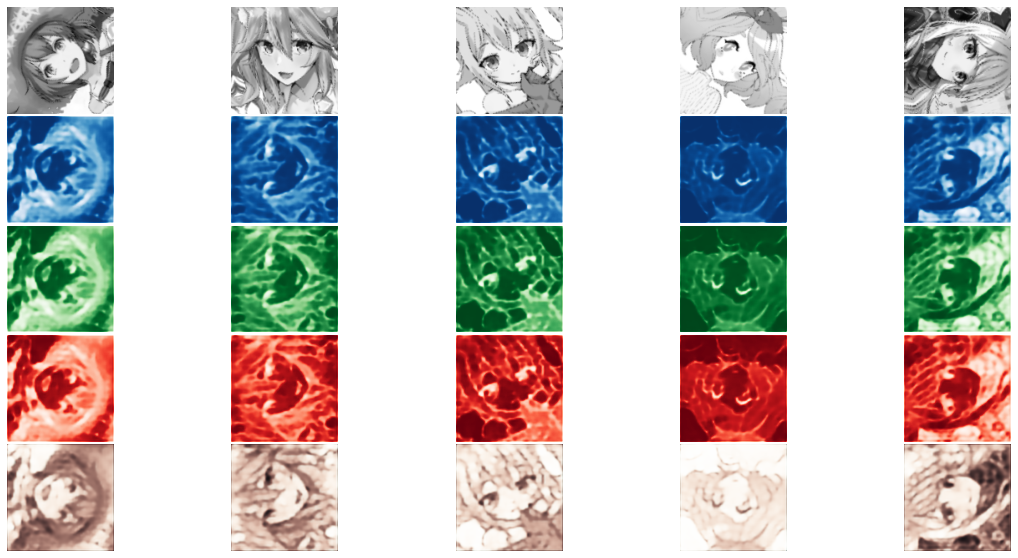

In [ ]:
fig = showResult(model, train_images.take(1))
plt.show()


In [ ]:
anim_file = "{0}/anime-colorizing.gif".format(root_dir)

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{0}/animeColor*.png'.format(root_dir))
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Image(url=anim_file)


In [ ]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show()
    plt.savefig(title + ".png")


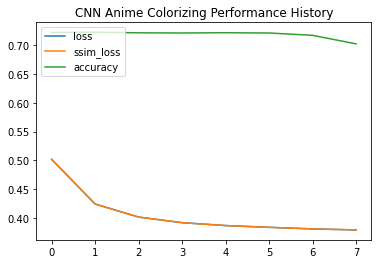

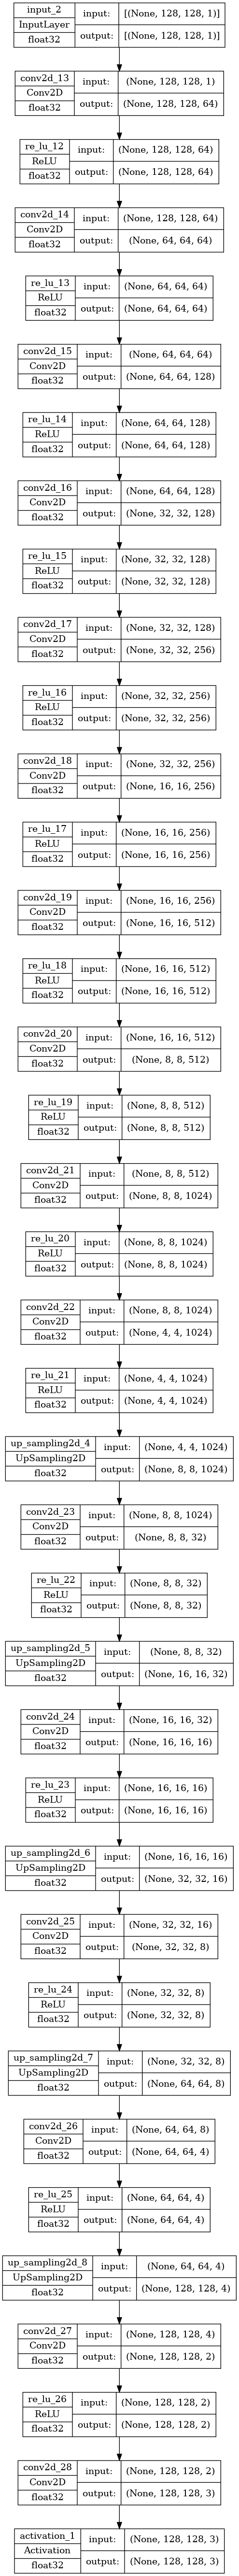

<Figure size 432x288 with 0 Axes>

In [ ]:
plotCostHistory(model_history.history, title=str.format(
    "CNN {0} Performance History", "Anime Colorizing"))

tf.keras.utils.plot_model(
    model, to_file=str.format('{0}/cnn_{1}_model.png', root_dir, "Anime Colorizing"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)
